Theory Questions:

 Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

 The minimax loss in GANs keeps the generator and discriminator in a competitive game. The generator tries to create realistic data, while the discriminator learns to distinguish real from fake. This ensures both improve over time, leading to more realistic generated outputs.

Q2: What is mode collapse, Why can mode collapse occur during GAN training? and
 how can it be mitigated?

 Mode collapse happens when the generator in a GAN produces limited variations of outputs instead of diverse, realistic samples. Instead of learning to generate a wide range of data, it keeps producing similar or repetitive outputs.

Mode collapse happens when the generator finds a shortcut to fool the discriminator with a few repeated patterns instead of learning the full data distribution. This can be caused by instability in training or when the discriminator gets too strong, making it hard for the generator to explore new outputs.


How to mitigate it?

Minibatch discrimination: Encourages diversity by comparing generated samples within a batch.

Wasserstein GAN (WGAN): Uses a more stable loss function to prevent sudden shifts in training.

Unrolling the discriminator: Allows the generator to adapt better by giving it more training steps.

Adding noise or regularization: Helps the generator explore different variations rather than sticking to repetitive outputs.

Q3: Explain the role of the discriminator in adversarial training?

The discriminator in adversarial training acts as a judge, distinguishing real data from fake data generated by the generator. It continuously improves by learning to detect fake samples, forcing the generator to create more realistic outputs. This adversarial process drives both networks to improve, ultimately leading to high-quality generated data.

 Q4: How do metrics like IS and FID evaluate GAN performance?

 Metrics like Inception Score (IS) and Fréchet Inception Distance (FID) help evaluate GAN performance by measuring the quality and diversity of generated images.

Inception Score (IS) assesses how realistic and varied the generated images are by using a pre-trained classifier (Inception model). Higher IS indicates better diversity and realism but does not compare to real data.
Fréchet Inception Distance (FID) compares the real and generated images by measuring the difference in their feature distributions. Lower FID values indicate more realistic and diverse images, making it a more reliable metric than IS.

In [ ]:
import tensorflow as tf
import tensorflow as tf
layers = tf.keras.layers
import matplotlib.pyplot as plt
import numpy as np
import os

# Enable GPU
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Load and preprocess CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_images = train_images.astype('float32')
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(32, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Create models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss  


# Function to save generated images
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(((predictions[i].numpy() * 127.5) + 127.5).astype(np.uint8))
        plt.axis('off')
    plt.savefig(f'gan_images/epoch_{epoch:04d}.png')
    plt.close()

# Training loop
gen_losses = []
disc_losses = []

def train(dataset, epochs):
    seed = tf.random.normal([16, 100])
    os.makedirs('gan_images', exist_ok=True)

    for epoch in range(epochs):
        gen_loss_total = 0
        disc_loss_total = 0
        step_count = 0

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            gen_loss_total += g_loss
            disc_loss_total += d_loss
            step_count += 1

        gen_losses.append(gen_loss_total / step_count)
        disc_losses.append(disc_loss_total / step_count)

        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch+1} completed, Gen Loss: {gen_losses[-1]:.4f}, Disc Loss: {disc_losses[-1]:.4f}')

    generate_and_save_images(generator, epochs, seed)


# Run training
train(train_dataset, epochs=200)


Num GPUs Available: 1
Epoch 1 completed, Gen Loss: 1.1957, Disc Loss: 1.0913
Epoch 2 completed, Gen Loss: 2.5126, Disc Loss: 0.5380
Epoch 3 completed, Gen Loss: 1.6696, Disc Loss: 0.7227
Epoch 4 completed, Gen Loss: 1.7981, Disc Loss: 0.7388
Epoch 5 completed, Gen Loss: 1.6674, Disc Loss: 0.9029
Epoch 6 completed, Gen Loss: 1.4055, Disc Loss: 0.8226
Epoch 7 completed, Gen Loss: 1.5649, Disc Loss: 0.7584
Epoch 8 completed, Gen Loss: 1.4529, Disc Loss: 1.0484
Epoch 9 completed, Gen Loss: 1.2614, Disc Loss: 1.0237
Epoch 10 completed, Gen Loss: 1.4035, Disc Loss: 0.8907
Epoch 11 completed, Gen Loss: 1.4929, Disc Loss: 0.9774
Epoch 12 completed, Gen Loss: 1.5119, Disc Loss: 0.7745
Epoch 13 completed, Gen Loss: 1.6421, Disc Loss: 1.0087
Epoch 14 completed, Gen Loss: 1.4194, Disc Loss: 0.9174
Epoch 15 completed, Gen Loss: 1.1512, Disc Loss: 1.1644
Epoch 16 completed, Gen Loss: 1.4703, Disc Loss: 0.9930
Epoch 17 completed, Gen Loss: 1.1831, Disc Loss: 1.0791
Epoch 18 completed, Gen Loss: 1.295

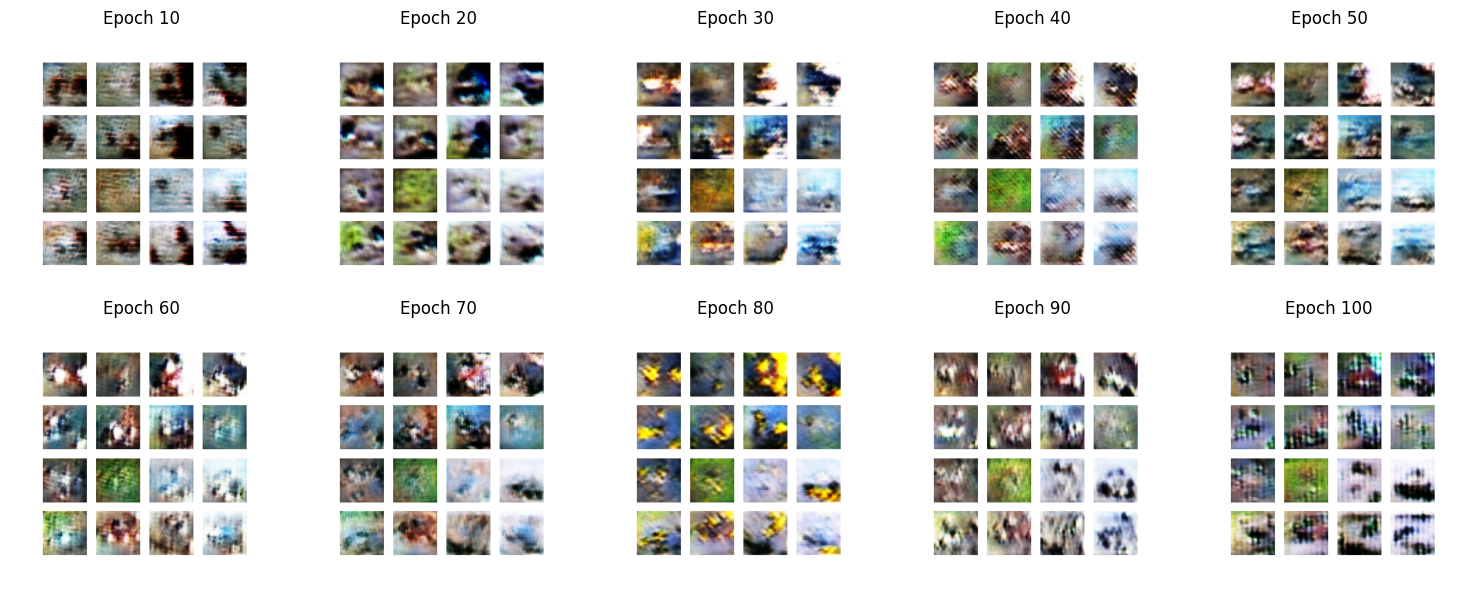

In [ ]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

# Load and display saved images
image_files = sorted(glob.glob("gan_images/*.png"))  

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, img_path in enumerate(image_files[-10:]):  
    img = Image.open(img_path)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis("off")
    axes[i // 5, i % 5].set_title(f"Epoch {((i+1)*10)}")

plt.tight_layout()
plt.show()


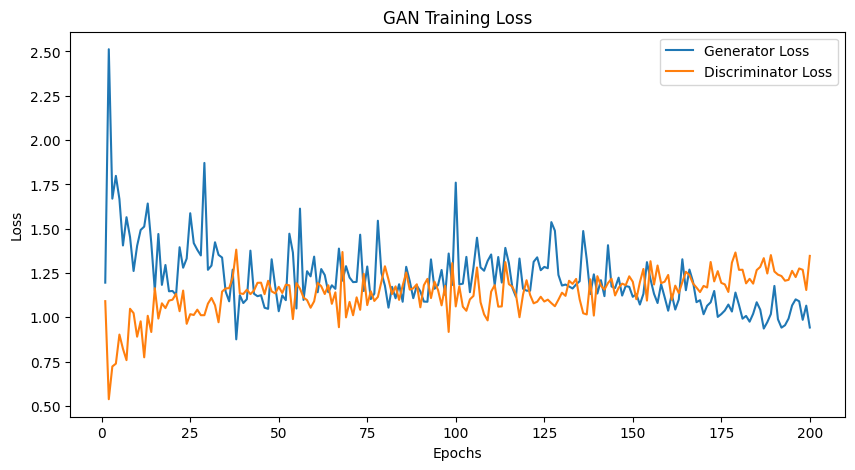

In [ ]:
import matplotlib.pyplot as plt

# Assuming loss lists were collected during training
epochs_range = list(range(1, 201))  

plt.figure(figsize=(10,5))
plt.plot(epochs_range, gen_losses, label="Generator Loss")
plt.plot(epochs_range, disc_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Training Loss")
plt.show()
